# Cuaderno para Hacer y Aplicar un modelo de Regresión a las puntuaciones de IMDb

## Librerías

In [233]:
import numpy as np
import pandas as pd
import fasttext
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import pickle

## Datos

In [155]:
df_script = pd.read_csv('The Saimpsons Archive/in_use/simpsons_script_lines.csv')
df_script.sample()

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
134292,144658,517,28,(Smart Tykes: ext. smart tykes - day - establi...,165000,False,NaN,4140.0,NaN,Smart Tykes,NaN,NaN,0.0


In [156]:
df_ep = pd.read_csv('The Saimpsons Archive/in_use/simpsons_episodes.csv')
df_ep.sample()

,id,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,views
358,148,8.6,1110.0,20,148,1996-03-31,1996,3F17,7,Bart on the Road,11.8,70913.0


In [157]:
df = pd.merge(left=df_script[['episode_id', 'raw_text']], right=df_ep[['id', 'imdb_rating']], left_on='episode_id', right_on='id')
df.sample()

,episode_id,raw_text,id,imdb_rating
53882,217,"Marge Simpson: Oh, isn't that sweet. (SIGH)",217,7.3


In [158]:
df = df.drop('id', axis=1)
df.sample()

,episode_id,raw_text,imdb_rating
36171,145,Barney Gumble: (LOUD BELCH),8.9


In [159]:
df.shape, df.isna().sum(), df.dtypes

((158270, 3),
 episode_id     0
 raw_text       0
 imdb_rating    0
 dtype: int64,
 episode_id       int64
 raw_text        object
 imdb_rating    float64
 dtype: object)

In [160]:
def join_text(text):
    return ' '.join(text)

def join_number(number):
    return number.mean()

In [161]:
df_agg = df.groupby('episode_id').agg({
    'raw_text':join_text,
    'imdb_rating':join_number
})
df_agg.sample()

,raw_text,imdb_rating
episode_id,,
486,Groundskeeper Willie: Me bleachers have been w...,7.0


In [162]:
df_agg=df_agg.reset_index()
df_agg

,episode_id,raw_text,imdb_rating
0,1,(Street: ext. street - establishing - night) (...,8.2
1,2,Bart Simpson: I'll pay! How much? (Simpson Liv...,7.8
2,3,Rod #2: (FROM SCREEN) We're radioactive! Rod #...,7.5
3,4,"Bart Simpson: Oh, yeah? Lisa Simpson: Yeah! Ba...",7.8
4,5,Bart Simpson: Here? Marge Simpson: These are f...,8.1
...,...,...,...
559,564,(Simpson Home: ext. simpson house - backyard -...,5.8
560,565,Milhouse Van Houten: AND OUR DENTISTS ARE ALL ...,6.3
561,566,(Theater: ext. theater - night) Singers: (SING...,6.7
562,567,Workman: Forty-three is missing again! (FIVE S...,6.6


# Word embedding

In [163]:
text_column = df_agg['raw_text']

model_embedding = fasttext.train_supervised(input="The Saimpsons Archive/in_use/text_data_train_fasttext.txt", lr=0.1, epoch=25, wordNgrams=2)

# Function to obtain FastText embeddings for a single text
def get_fasttext_embedding(text):
    text = text.replace('\n', '')
    return model_embedding.get_sentence_vector(text)

# Apply the function to each text in the DataFrame column
embeddings = text_column.apply(get_fasttext_embedding)

# Convert embeddings to DataFrame
embedding_df = pd.DataFrame(embeddings.tolist(), columns=[f'embedding_{i}' for i in range(embeddings.iloc[0].shape[0])])

# Concatenate the embedding DataFrame with the original DataFrame
result_df = pd.concat([df_agg[['episode_id', 'imdb_rating']], embedding_df], axis=1)

Read 1M words
Number of words:  137245
Number of labels: 0
Progress: 100.0% words/sec/thread: 12645634 lr:  0.000000 avg.loss:       nan ETA:   0h 0m 0s


In [164]:
result_df.shape, result_df.isna().sum()

((564, 102),
 episode_id      0
 imdb_rating     0
 embedding_0     0
 embedding_1     0
 embedding_2     0
                ..
 embedding_95    0
 embedding_96    0
 embedding_97    0
 embedding_98    0
 embedding_99    0
 Length: 102, dtype: int64)

In [165]:
result_df.sample()

,episode_id,imdb_rating,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
358,359,7.0,0.000192,0.000322,-0.00013,-0.000082,0.000225,0.000255,-0.000214,-0.000139,...,0.0003,-0.000099,0.000575,-0.000289,-0.000306,-0.000648,-0.00047,0.000226,-0.000137,-0.000509


# Probando modelos Regresión

## Regresión lineal:

In [166]:
df_train, df_test = train_test_split(result_df, test_size=0.2, random_state=1989)

# Dividir el DataFrame en características (X) y etiquetas (y)
X_train = df_train.drop(['imdb_rating', 'episode_id'], axis=1) 
y_train = df_train['imdb_rating']
X_test = df_test.drop(['imdb_rating', 'episode_id'], axis=1) 
y_test = df_test['imdb_rating']

# Aplicar PCA
pca = PCA(n_components=0.8)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

# Escalar características para normalizarlas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_pca_train)
X_test_scaled = scaler.transform(X_pca_test)


In [167]:
# modelo
model = LinearRegression()

# Fit the model
model.fit(X_train_scaled, y_train)

# predicciones
y_pred_rl = model.predict(X_test_scaled)

y_pred_rl_train = model.predict(X_train_scaled)

# Evaluación
mse = mean_squared_error(y_test, y_pred_rl)
r2 = r2_score(y_test, y_pred_rl)
mae = mean_absolute_error(y_test, y_pred_rl)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("MAE:", mae)

Mean Squared Error: 0.4230441890759124
R-squared: 0.2667462222802447
MAE: 0.5098242295526824


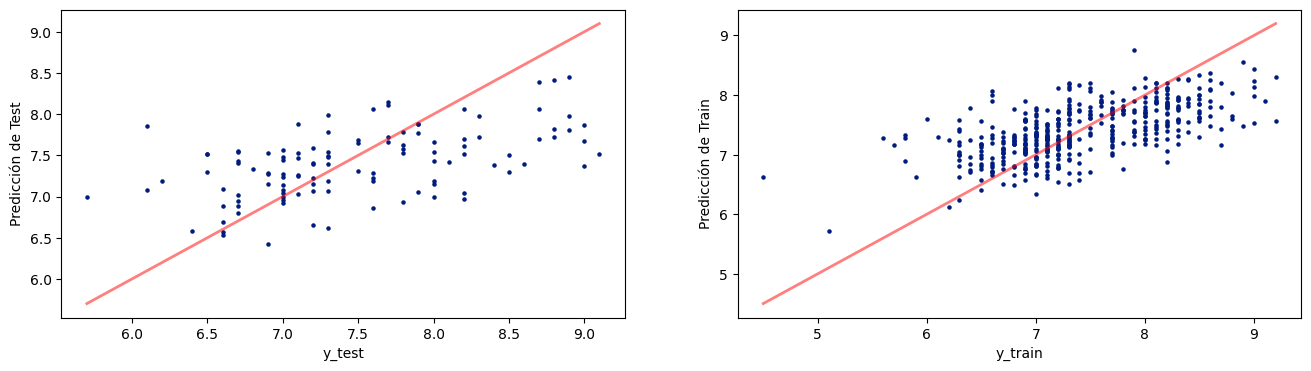

In [168]:
# Visualiza la predicción vs. los datos reales
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].scatter(x=y_test, y=y_pred_rl, s=5, label='Predicción vs. Realidad')
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, alpha=.5)
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('Predicción de Test')

ax[1].scatter(x=y_train, y=y_pred_rl_train, s=5, label='Predicción vs. Realidad')
ax[1].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, alpha=.5)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('Predicción de Train')

plt.show()

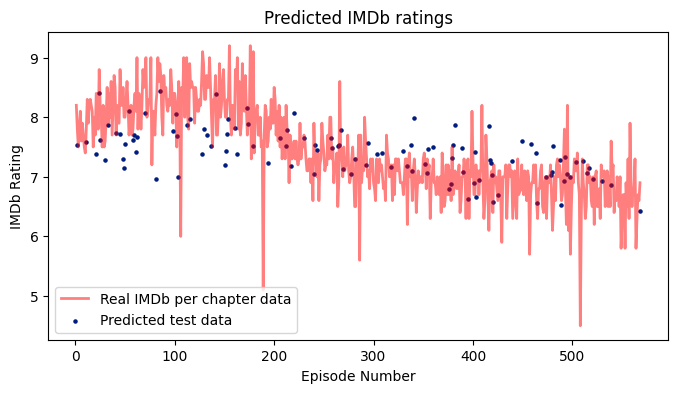

In [229]:
f, ax = plt.subplots(figsize=(8,4))
plt.plot(result_df['episode_id'], result_df['imdb_rating'], color='red', lw=2, alpha=.5, label='Real IMDb per chapter data')
plt.scatter(df_test['episode_id'], y_pred_rl, s=5, label='Predicted test data')
plt.title('Predicted IMDb ratings')
plt.xlabel('Episode Number')
plt.ylabel('IMDb Rating')
plt.legend(loc='lower left')
plt.show()

## GradientBoostingRegressor

In [218]:
model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=1989)
model.fit(X_train_scaled, y_train)

y_pred_gbr = model.predict(X_test_scaled)

y_pred_gbr_train = model.predict(X_train_scaled)

mse = mean_squared_error(y_test, y_pred_gbr)
r2 = r2_score(y_test, y_pred_gbr)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.46357506409367777
R-squared: 0.1964948915954241


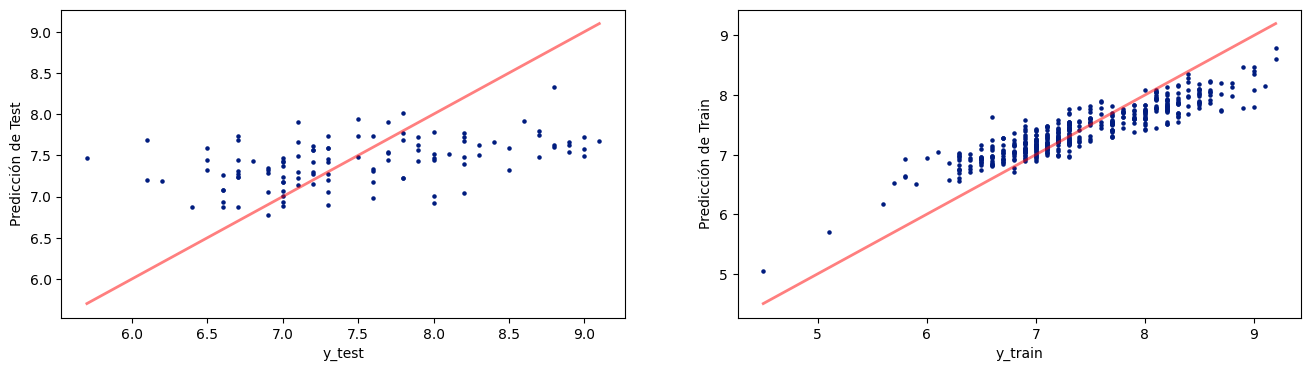

In [219]:
# Visualiza la predicción vs. los datos reales
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].scatter(x=y_test, y=y_pred_gbr, s=5, label='Predicción vs. Realidad')
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, alpha=.5)
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('Predicción de Test')

ax[1].scatter(x=y_train, y=y_pred_gbr_train, s=5, label='Predicción vs. Realidad')
ax[1].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, alpha=.5)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('Predicción de Train')

plt.show()

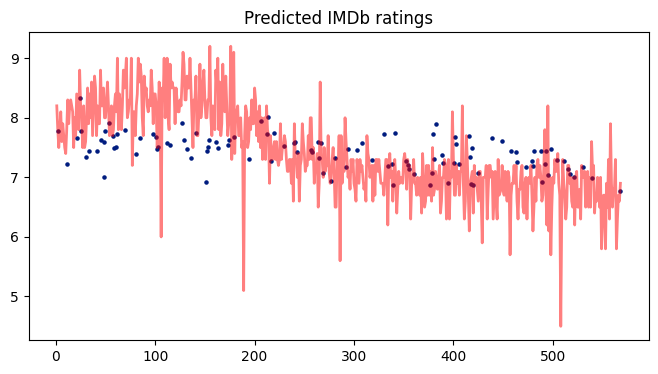

In [220]:
f, ax = plt.subplots(figsize=(8,4))
plt.plot(result_df['episode_id'], result_df['imdb_rating'], color='red', lw=2, alpha=.5)
plt.scatter(df_test['episode_id'], y_pred_gbr, s=5)
plt.title('Predicted IMDb ratings')
plt.show()

## SVR: Supported Vector Machine Regressor

In [173]:
model = SVR(kernel='rbf', C=0.2)
model.fit(X_train_scaled, y_train)

y_pred_svr = model.predict(X_test_scaled)

y_pred_svr_train = model.predict(X_train_scaled)

# Evaluación
mse = mean_squared_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)
mae = mean_absolute_error(y_test, y_pred_svr)

print("Mean Squared Error:", mse)
print("MAE:", mae)

Mean Squared Error: 0.46786907009584083
MAE: 0.5393160819761962


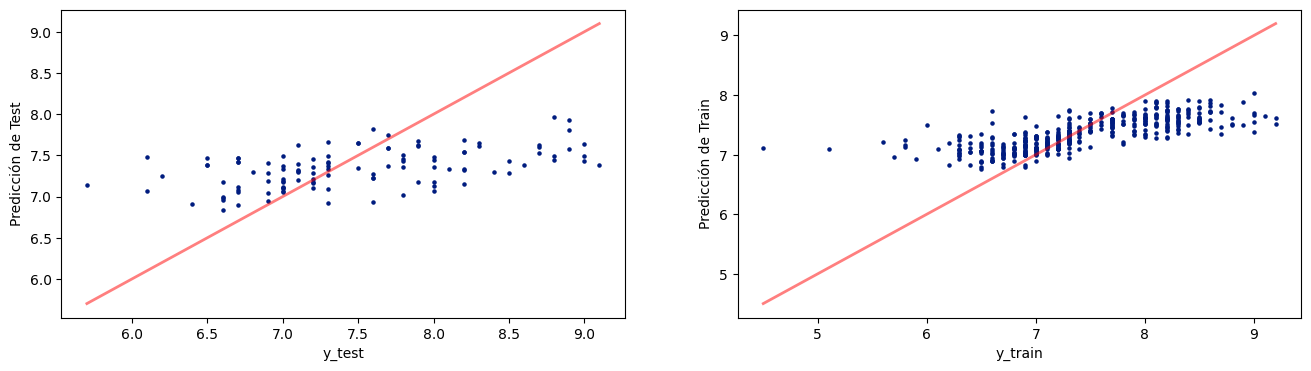

In [174]:
# Visualiza la predicción vs. los datos reales
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].scatter(x=y_test, y=y_pred_svr, s=5, label='Predicción vs. Realidad')
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, alpha=.5)
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('Predicción de Test')

ax[1].scatter(x=y_train, y=y_pred_svr_train, s=5, label='Predicción vs. Realidad')
ax[1].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, alpha=.5)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('Predicción de Train')

plt.show()

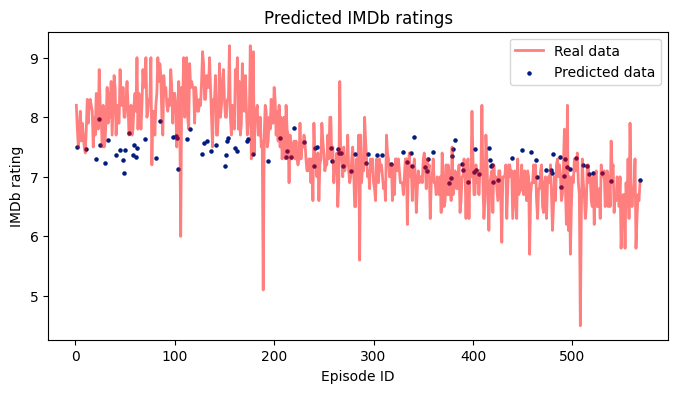

In [175]:
f, ax = plt.subplots(figsize=(8,4))
plt.plot(result_df['episode_id'], result_df['imdb_rating'], color='red', lw=2, alpha=.5, label='Real data')
plt.scatter(df_test['episode_id'], y_pred_svr, s=5, label='Predicted data')
plt.xlabel('Episode ID')
plt.ylabel('IMDb rating')
plt.title('Predicted IMDb ratings')
plt.legend()
plt.show()

## Optimizaciones SVR pre-PCA

In [176]:
result_df.sample()

,episode_id,imdb_rating,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
135,136,8.5,0.000313,0.000136,-0.000072,-0.000052,0.000425,0.000033,-0.000294,-0.000107,...,0.000185,-0.000056,0.000622,-0.000332,-0.000223,-0.000365,-0.000078,0.000315,-0.00028,-0.000234


In [177]:
X = result_df.drop(['imdb_rating', 'episode_id'], axis=1) 
y = result_df['imdb_rating']

In [178]:
pipe1_svr = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
grid_params = {
    'svr__kernel' : ['rbf'], #['linear', 'poly', 'rbf', 'sigmoid'],
    'svr__C' : np.linspace(0.001, 1, 40)
}
gs1_svr= GridSearchCV(pipe1_svr, grid_params, cv = 5, verbose=1, scoring= 'neg_mean_squared_error',return_train_score=True)

In [179]:
svr_model1 = gs1_svr.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [180]:
#Comprobamos diferencia entre train y test
df_res = pd.DataFrame(gs1_svr.cv_results_['params'])
df_res['test_result'] = gs1_svr.cv_results_['mean_test_score']
df_res ['train_result'] = gs1_svr.cv_results_['mean_train_score']
df_res.sample()

,svr__C,svr__kernel,test_result,train_result
6,0.154692,rbf,-0.65181,-0.334609


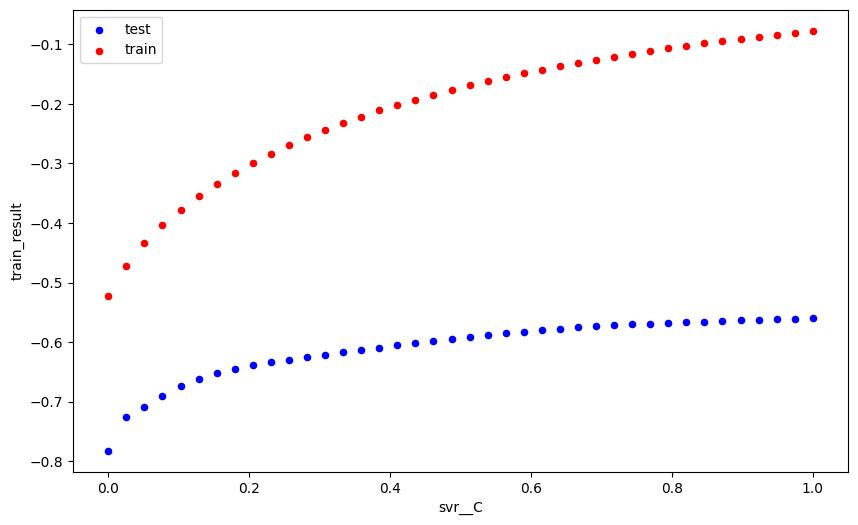

In [181]:
fig, ax = plt.subplots(figsize=(10,6))
df_res.plot.scatter('svr__C', 'test_result', label='test', ax=ax, color='blue')
df_res.plot.scatter('svr__C', 'train_result', label='train', ax=ax, color='red')
plt.legend()

### Resultados primera optimización de los tres parámetros: C = 0.5; kernel rbf.

### Resultados optimización C fijando kernel en rbf: 0.2

## Decission tree

In [223]:
model = DecisionTreeRegressor(random_state=1989, max_depth=5)
model.fit(X_train_scaled, y_train)

y_pred_dtr = model.predict(X_test_scaled)

y_pred_dtr_train = model.predict(X_train_scaled)

mse = mean_squared_error(y_test, y_pred_dtr)
r2 = r2_score(y_test, y_pred_dtr)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.649771372569056
R-squared: -0.1262353340230271


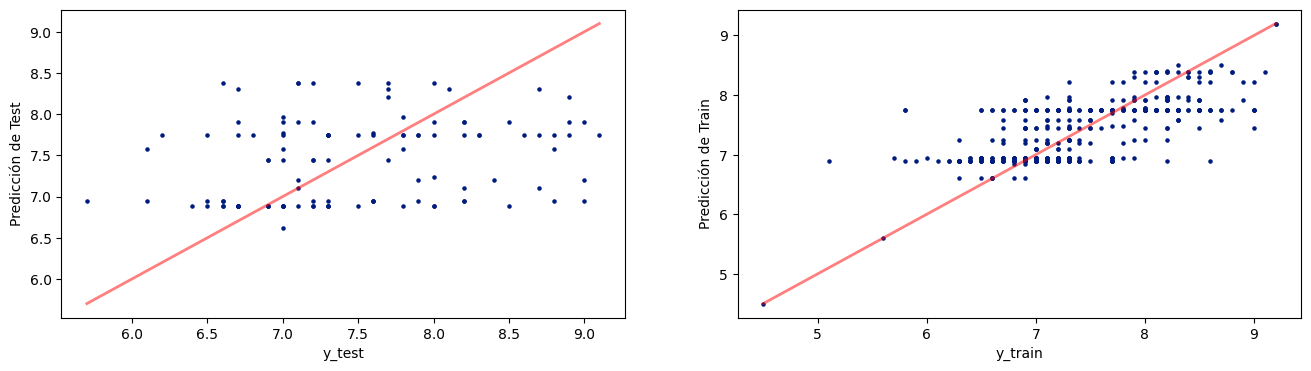

In [224]:
# Visualiza la predicción vs. los datos reales
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].scatter(x=y_test, y=y_pred_dtr, s=5, label='Predicción vs. Realidad')
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, alpha=.5)
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('Predicción de Test')

ax[1].scatter(x=y_train, y=y_pred_dtr_train, s=5, label='Predicción vs. Realidad')
ax[1].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, alpha=.5)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('Predicción de Train')

plt.show()

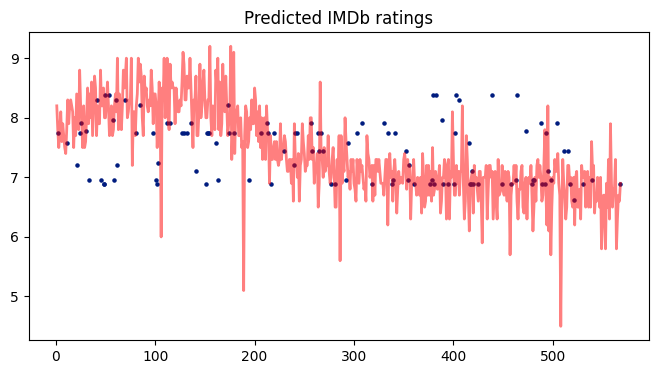

In [225]:
f, ax = plt.subplots(figsize=(8,4))
plt.plot(result_df['episode_id'], result_df['imdb_rating'], color='red', lw=2, alpha=.5)
plt.scatter(df_test['episode_id'], y_pred_dtr, s=5)
plt.title('Predicted IMDb ratings')
plt.show()

## Random Forest Regressor

In [185]:
model = RandomForestRegressor(random_state=1989, n_estimators=50, max_depth=5)
model.fit(X_train_scaled, y_train)

y_pred_rfr = model.predict(X_test_scaled)

y_pred_rfr_train = model.predict(X_train_scaled)

mse = mean_squared_error(y_test, y_pred_rfr)
r2 = r2_score(y_test, y_pred_rfr)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.49200278259557473
R-squared: 0.14722171276036555


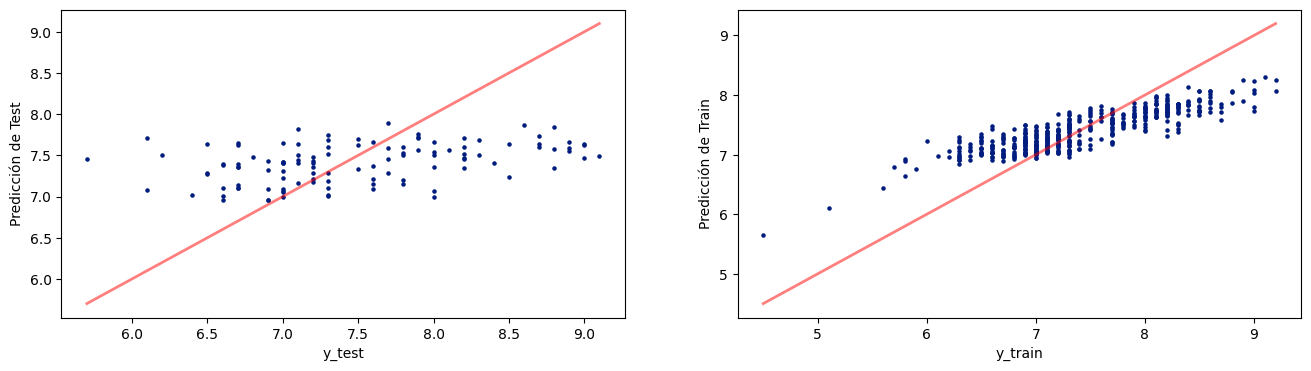

In [186]:
# Visualiza la predicción vs. los datos reales
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].scatter(x=y_test, y=y_pred_rfr, s=5, label='Predicción vs. Realidad')
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, alpha=.5)
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('Predicción de Test')

ax[1].scatter(x=y_train, y=y_pred_rfr_train, s=5, label='Predicción vs. Realidad')
ax[1].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, alpha=.5)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('Predicción de Train')

plt.show()

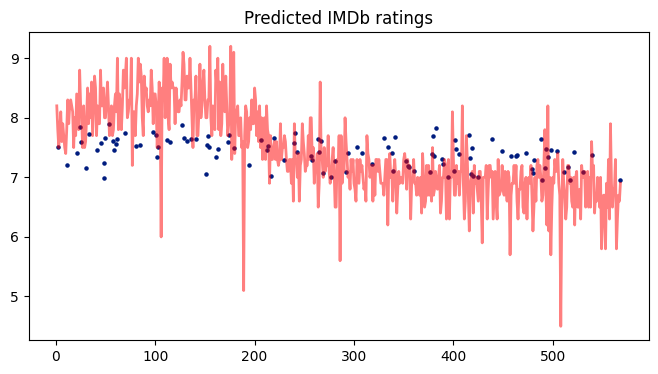

In [187]:
f, ax = plt.subplots(figsize=(8,4))
plt.plot(result_df['episode_id'], result_df['imdb_rating'], color='red', lw=2, alpha=.5)
plt.scatter(df_test['episode_id'], y_pred_rfr, s=5)
plt.title('Predicted IMDb ratings')
plt.show()

## Polinomial degree 2 and 3

### d=2

In [188]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)  # Adjust degree as needed
X_train_poly2 = poly.fit_transform(X_train_scaled)
X_test_poly2 = poly.transform(X_test_scaled)

# Create Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train_poly2, y_train)

# Make predictions
y_pred_pd2 = model.predict(X_test_poly2)
y_pred_pd2_train = model.predict(X_train_poly2)

# Evaluation
mse = mean_squared_error(y_test, y_pred_pd2)
r2 = r2_score(y_test, y_pred_pd2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.9407961411730968
R-squared: -0.6306625699934953


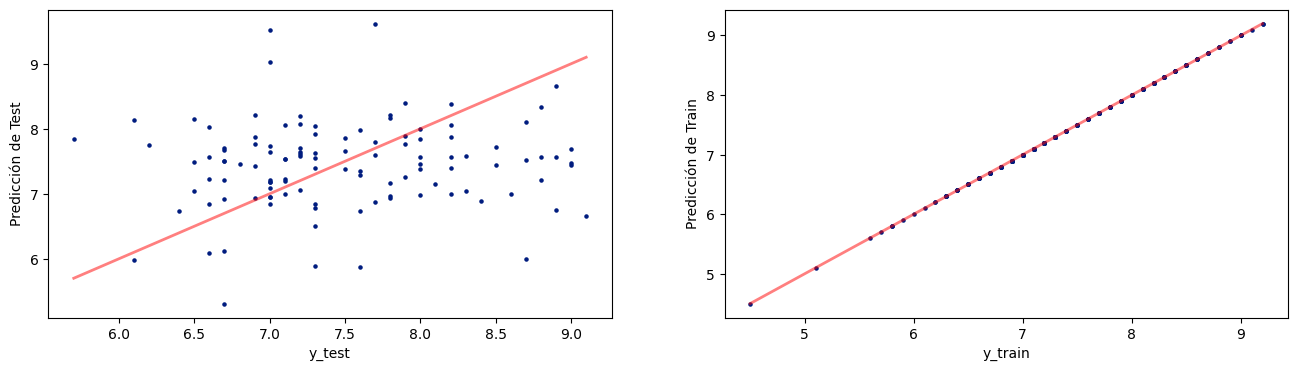

In [189]:
# Visualiza la predicción vs. los datos reales
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].scatter(x=y_test, y=y_pred_pd2, s=5, label='Predicción vs. Realidad')
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, alpha=.5)
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('Predicción de Test')

ax[1].scatter(x=y_train, y=y_pred_pd2_train, s=5, label='Predicción vs. Realidad')
ax[1].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, alpha=.5)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('Predicción de Train')

plt.show()

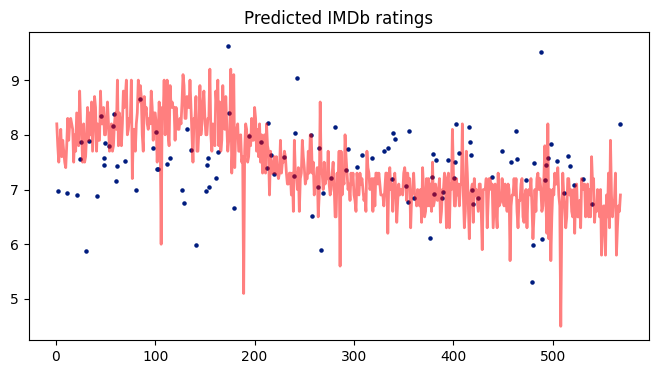

In [190]:
f, ax = plt.subplots(figsize=(8,4))
plt.plot(result_df['episode_id'], result_df['imdb_rating'], color='red', lw=2, alpha=.5)
plt.scatter(df_test['episode_id'], y_pred_pd2, s=5)
plt.title('Predicted IMDb ratings')
plt.show()

### d=3

In [191]:
# Create polynomial features
poly = PolynomialFeatures(degree=3)  # Adjust degree as needed
X_train_poly3 = poly.fit_transform(X_train_scaled)
X_test_poly3 = poly.transform(X_test_scaled)

# Create Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train_poly3, y_train)

# Make predictions
y_pred_pd3 = model.predict(X_test_poly3)

y_pred_pd3_train = model.predict(X_train_poly3)

# Evaluation
mse = mean_squared_error(y_test, y_pred_pd3)
r2 = r2_score(y_test, y_pred_pd3)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.4248893054845955
R-squared: 0.2635481200206322


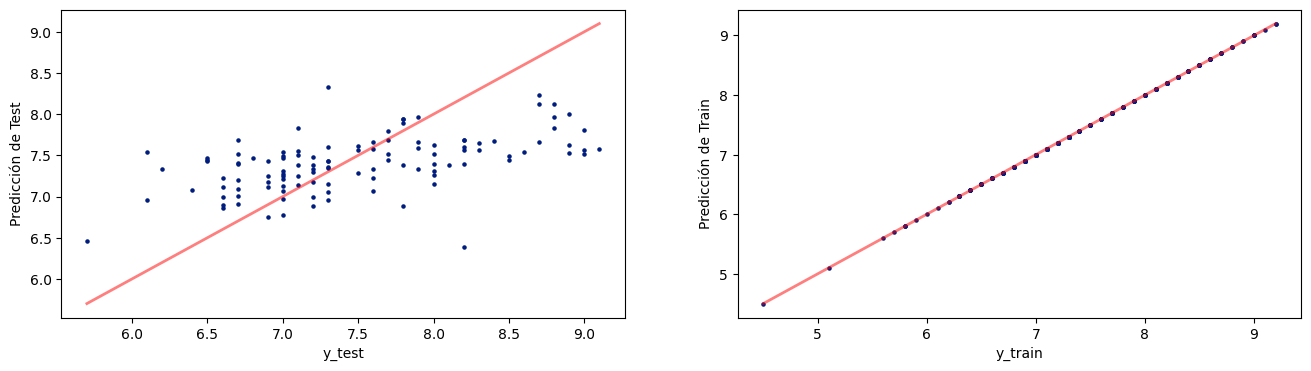

In [192]:
# Visualiza la predicción vs. los datos reales
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].scatter(x=y_test, y=y_pred_pd3, s=5, label='Predicción vs. Realidad')
ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, alpha=.5)
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('Predicción de Test')

ax[1].scatter(x=y_train, y=y_pred_pd3_train, s=5, label='Predicción vs. Realidad')
ax[1].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, alpha=.5)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('Predicción de Train')

plt.show()

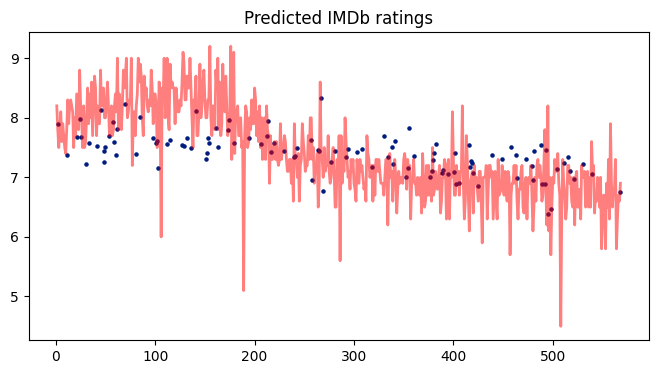

In [193]:
f, ax = plt.subplots(figsize=(8,4))
plt.plot(result_df['episode_id'], result_df['imdb_rating'], color='red', lw=2, alpha=.5)
plt.scatter(df_test['episode_id'], y_pred_pd3, s=5)
plt.title('Predicted IMDb ratings')
plt.show()

## Red Neuronal

In [194]:
def scheduler(epoch, lr):
    return lr * np.exp(-0.2)

lr_schedule = LearningRateScheduler(scheduler)

In [195]:
# random_state = 1989
tf.random.set_seed(1989)
np.random.seed(1989)

f=X_train_scaled.shape[1]

modelo_rn = Sequential()

modelo_rn.add(Dense(64, activation='relu', input_dim=f)) ## relu es porque es regresión, y el input tiene que ir sólo en la primera capa.
modelo_rn.add(Dense(1)) # Capa de salida, tiene que ser solo 1, para que los datos converjan y tener sólo un resultado.

adam = Adam(learning_rate=.05) # La velocidad de aprendizaje del modelo por epoch.

modelo_rn.compile(optimizer=adam, loss='mse') #Compilando el modelo

In [196]:
history = modelo_rn.fit(X_train_scaled, y_train, batch_size=2, epochs=15, verbose=False, validation_split=.1, callbacks=[lr_schedule])

In [197]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

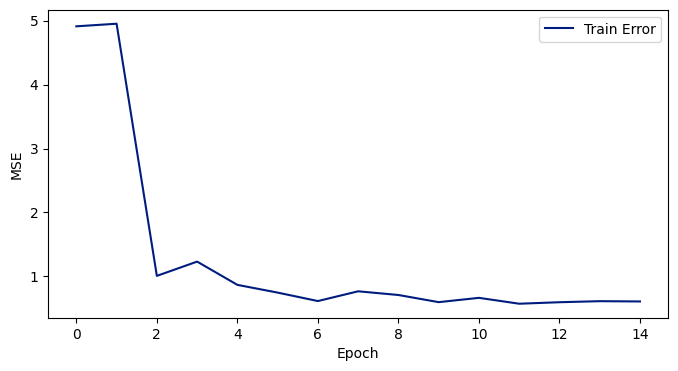

In [198]:
plt.figure(figsize=(8,4))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(hist['epoch'], hist['val_loss'], label='Train Error')
plt.legend()
plt.show()

In [199]:
y_pred_rn = modelo_rn.predict(X_test_scaled)

4/4 [==============================] - 0s 4ms/step


In [200]:
print(f'MAE:  {mean_absolute_error(y_test, y_pred_rn):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rn)):.2f}')

MAE:  0.66
RMSE: 0.82


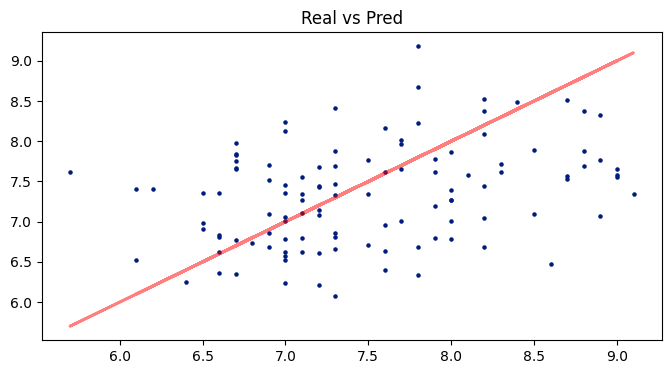

In [201]:
f, ax = plt.subplots(figsize=(8,4))
plt.plot(y_test, y_test, color='red', lw=2, alpha=.5)
plt.scatter(y_test, y_pred_rn, s=5)
plt.title('Real vs Pred')
plt.show()

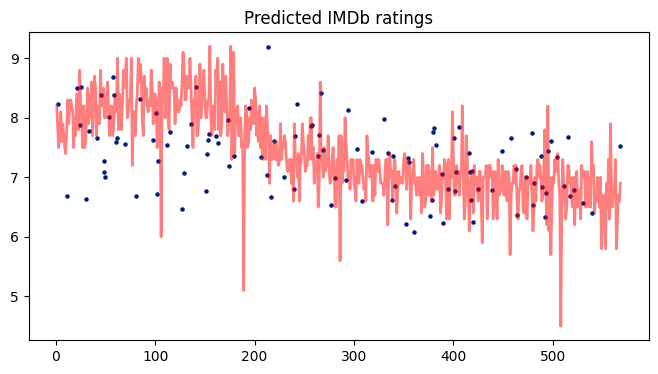

In [202]:
f, ax = plt.subplots(figsize=(8,4))
plt.plot(result_df['episode_id'], result_df['imdb_rating'], color='red', lw=2, alpha=.5)
plt.scatter(df_test['episode_id'], y_pred_rn, s=5)
plt.title('Predicted IMDb ratings')
plt.show()

# Entrenando modelo final

In [203]:
# X = result_df.drop(['imdb_rating', 'episode_id'], axis=1) 
# y = result_df['imdb_rating']

# X_scaled = scaler.fit_transform(X)

In [204]:
# final_model_svr = SVR(kernel='rbf', C=0.2)
# final_model_svr.fit(X, y)

SVR(C=0.2)

In [205]:
# import pickle

# with open('Modelos/Regresión/model_svr.pkl', 'wb') as f:
#     pickle.dump(final_model_svr, f)

In [234]:
X = result_df.drop(['imdb_rating', 'episode_id'], axis=1) 
y = result_df['imdb_rating']

X_pca = pca.fit_transform(X)
X_scaled = scaler.fit_transform(X)

In [235]:
with open('Modelos/Regresión/pca_regression.pkl', 'wb') as f:
    pickle.dump(pca, f)

with open('Modelos/Regresión/scaler_regression.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [236]:
final_model_rl = LinearRegression()
final_model_rl.fit(X, y)

LinearRegression()

In [237]:
with open('Modelos/Regresión/model_rl.pkl', 'wb') as f:
    pickle.dump(final_model_rl, f)

# Aplicando modelo final a escenas generadas

In [238]:
df_respuestas = pd.read_csv('The Saimpsons Archive/Respuestas/respuestas_LLMs.csv')
df_respuestas.sample()

,fine_tuned,input_character_raw,input_location_raw,raw_text,id,location_output
15,True,NaN,Simpson home,(Simpson home: ext. simpson house)\nMarge Simp...,ft1_char0_loc1_0,simpson home


## Aplicando word embedding a raw_text respuestas

In [239]:
text_column = df_respuestas['raw_text']
embeddings_respuestas = text_column.apply(get_fasttext_embedding)

# Convert embeddings_respuestas to DataFrame
embedding_respuestas_df = pd.DataFrame(embeddings_respuestas.tolist(), columns=[f'embedding_{i}' for i in range(embeddings_respuestas.iloc[0].shape[0])])

# Concatenate the embedding DataFrame with the original DataFrame
result_df_resp = pd.concat([df_respuestas.drop('raw_text',axis=1), embedding_respuestas_df], axis=1)

In [240]:
result_df_resp.isna().sum()

fine_tuned              0
input_character_raw    13
input_location_raw     16
id                      0
location_output         2
                       ..
embedding_95            0
embedding_96            0
embedding_97            0
embedding_98            0
embedding_99            0
Length: 105, dtype: int64

In [241]:
result_df_resp.shape

(33, 105)

In [242]:
result_df_resp.sample()

,fine_tuned,input_character_raw,input_location_raw,id,location_output,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
11,False,NaN,NaN,ft0_char0_loc0_2,simpson living room,0.000104,0.000495,-0.000226,-0.000185,0.000425,...,0.000501,0.000409,0.000923,-0.000539,-0.000082,-0.000099,-0.000186,0.000335,-0.000341,-0.0004


## Predicciones:

In [243]:
y_respuestas = result_df_resp.drop(['fine_tuned', 'input_character_raw', 'input_location_raw', 'id', 'location_output'], axis=1)

In [244]:
predicciones = final_model_rl.predict(y_respuestas)

In [245]:
df_respuestas['predicciones'] = predicciones
df_respuestas.head()

,fine_tuned,input_character_raw,input_location_raw,raw_text,id,location_output,predicciones
0,True,NaN,NaN,(The Simpsons: ext. simpsons' house - morning ...,ft1_char0_loc0_0,simpson house,4.552698
1,True,"['Homer Simpson', 'Bart Simpson']",NaN,"(Homer Simpson: AD LIB OF ""YEAH"" WITH A MOUTHF...",ft1_char1_loc0_0,NaN,2.310926
2,True,"['Bart Simpson', 'Lisa Simpson', 'Milhouse Van...",NaN,"Bart Simpson: (SINCERE) I'm glad you're back, ...",ft1_char1_loc0_1,NaN,7.160313
3,True,"['Homer Simpson', 'C. Montgomery Burns', 'Wayl...",NaN,(ANOTHER PART OF THE ESTATE - CONTINUOUS)\nC. ...,ft1_char1_loc0_2,burns estate,5.898315
4,True,"['Homer Simpson', 'Grampa Simpson', 'Helen Lov...",Springfield Retirement Castle,(Springfield Retirement Castle: EXT. RETIREMEN...,ft1_char1_loc1_0,springfield retirement castle,7.604988


## Representaciones de las predicciones

In [246]:
df_respuestas['character_input?'] = df_respuestas['input_character_raw'].notna()
df_respuestas['location_input?'] = df_respuestas['input_location_raw'].notna()

In [247]:
df_respuestas.sample()

,fine_tuned,input_character_raw,input_location_raw,raw_text,id,location_output,predicciones,character_input?,location_input?
28,False,"['Homer Simpson', 'Moe Szyslak']",Moe's Tavern,"(Interior: Moe's Tavern. Homer, Moe, Barney, L...",ft0_char1_loc1_0,moe tavern,8.461522,True,True


In [248]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


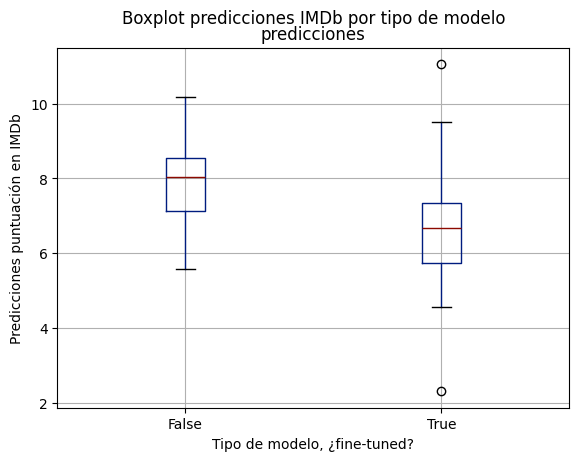

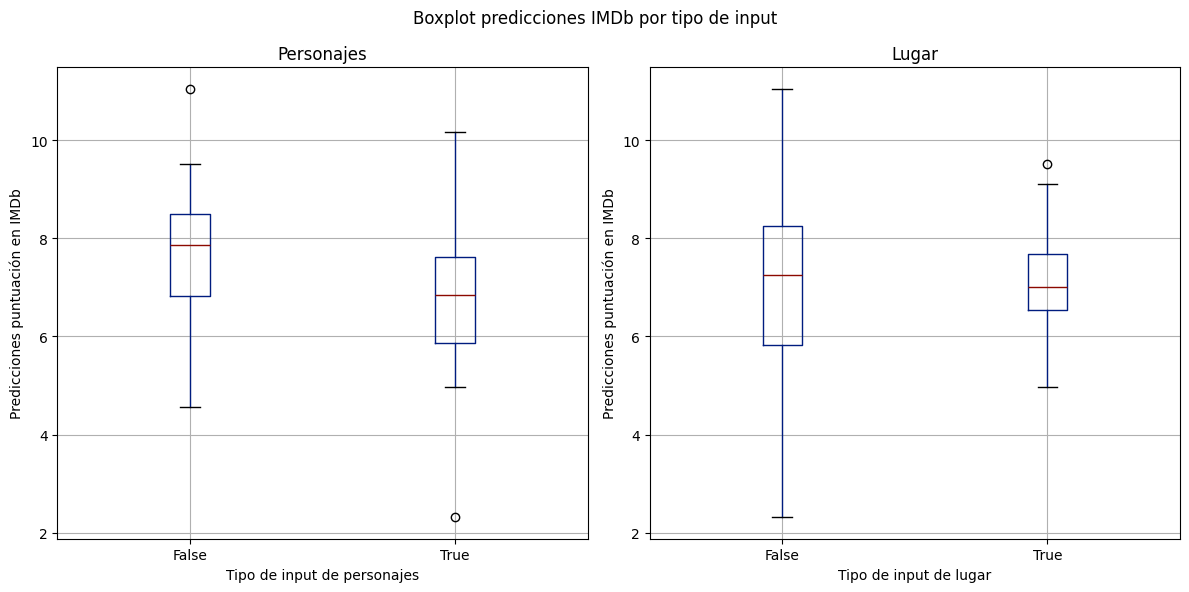

In [249]:
plt.style.use('seaborn-v0_8-dark-palette')


df_respuestas.boxplot(column='predicciones', by='fine_tuned')
plt.suptitle('Boxplot predicciones IMDb por tipo de modelo')
plt.xlabel('Tipo de modelo, ¿fine-tuned?')
plt.ylabel('Predicciones puntuación en IMDb')


# Crear la figura y los subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

df_respuestas.boxplot(column='predicciones', by='character_input?', ax=ax[0])
ax[0].set_title('Personajes')
ax[0].set_xlabel('Tipo de input de personajes')
ax[0].set_ylabel('Predicciones puntuación en IMDb')

df_respuestas.boxplot(column='predicciones', by='location_input?', ax=ax[1])
ax[1].set_title('Lugar')
ax[1].set_xlabel('Tipo de input de lugar')
ax[1].set_ylabel('Predicciones puntuación en IMDb')

fig.suptitle('Boxplot predicciones IMDb por tipo de input')


# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()
